In [3]:
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import pandas as pd
import h5py
import vector
import coffea
import coffea.util
from math import sqrt
vector.register_numba()
vector.register_awkward()

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
import mplhep as hep
#hep.style.use(hep.style.ROOT)

In [4]:
# prefix="/run/user/1000/gvfs/sftp:host=lxplus.cern.ch,user=mmalucch/"
# filename_test = prefix+"/eos/home-m/mmalucch/spanet_inputs/output_JetGoodHiggs_test.h5"
# filename_test="/work/mmalucch/out_hh4b/hh4b_btag_in_presel_0pad/output_JetGoodHiggs_test.h5"
# filename_test = prefix+"/eos/home-m/mmalucch/spanet_inputs/zero_padding/output_JetGoodHiggs_test.h5"
# filename_pred = prefix+"/eos/home-r/ramellar/prediction.h5"
# filename_pred = "/home/matteo/Downloads/prediction.h5"
filename_pred="/work/mmalucch/prediction.h5"
filename_test="/work/mmalucch/out_hh4b/hh4b_btag_in_presel_0pad/output_JetGoodHiggs_test.h5"
df_test = h5py.File(filename_test,'r')
df_pred = h5py.File(filename_pred,'r')

In [5]:
df_test["INPUTS"]["FifthJet"]["btag"][()]


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [6]:
df_pred["TARGETS"]["h1"].keys()

<KeysViewHDF5 ['assignment_probability', 'b1', 'b2', 'detection_probability', 'marginal_probability']>

## Compute the jet assignment efficiency
We extract the predicted and true indices for the individual quarks.
Jets are correctly assigned when the predicted jet index is equal to the true index. We can compute the efficiency as the ratio of the correctly assigned jets over the total number of jets.

In [7]:
idx_b1_pred = df_pred["TARGETS"]["h1"]["b1"][()]
idx_b2_pred = df_pred["TARGETS"]["h1"]["b2"][()]
idx_b1_pred

array([0, 1, 0, ..., 2, 1, 0])

In [8]:
idx_b1_true = df_test["TARGETS"]["h1"]["b1"][()]
idx_b2_true = df_test["TARGETS"]["h1"]["b2"][()]
idx_b1_true

array([1, 0, 1, ..., 0, 0, 2])

In [9]:
idx_h1_pred = ak.concatenate((ak.unflatten(idx_b1_pred, ak.ones_like(idx_b1_pred)), ak.unflatten(idx_b2_pred, ak.ones_like(idx_b2_pred))), axis=1)
idx_h1_true = ak.concatenate((ak.unflatten(idx_b1_true, ak.ones_like(idx_b1_true)), ak.unflatten(idx_b2_true, ak.ones_like(idx_b2_true))), axis=1)
idx_h1_pred

<Array [[0, 2], [1, 2], ... [1, 3], [0, 1]] type='129710 * var * int64'>

In [10]:
print(idx_h1_pred)
print(idx_h1_true)

[[0, 2], [1, 2], [0, 3], [0, 2], [0, 1], ... [0, 2], [2, 3], [2, 3], [1, 3], [0, 1]]
[[1, 3], [0, 3], [1, 2], [0, 2], [2, 3], ... [1, 3], [2, 3], [0, 1], [0, 2], [2, 3]]


In [11]:
idx_b3_pred = df_pred["TARGETS"]["h2"]["b3"][()]
idx_b4_pred = df_pred["TARGETS"]["h2"]["b4"][()]
idx_b3_true = df_test["TARGETS"]["h2"]["b3"][()]
idx_b4_true = df_test["TARGETS"]["h2"]["b4"][()]

idx_h2_pred = ak.concatenate((ak.unflatten(idx_b3_pred, ak.ones_like(idx_b3_pred)), ak.unflatten(idx_b4_pred, ak.ones_like(idx_b4_pred))), axis=1)
idx_h2_true = ak.concatenate((ak.unflatten(idx_b3_true, ak.ones_like(idx_b3_true)), ak.unflatten(idx_b4_true, ak.ones_like(idx_b4_true))), axis=1)
print(idx_h2_pred)
print(idx_h2_true)

[[1, 3], [0, 3], [1, 2], [1, 3], [2, 3], ... [1, 3], [0, 1], [0, 1], [0, 2], [2, 3]]
[[0, 2], [1, 2], [0, 3], [1, -1], [0, 1], ... 0, -1], [0, 1], [2, 3], [1, 3], [0, 1]]


In [12]:
# order the true array in increasing order
idx_h1_true_order = ak.sort(idx_h1_true, axis=1)
idx_h1_true_order = idx_h1_true
print(idx_h1_true)
print(idx_h1_true_order)
print(ak.sum(idx_h1_true[:,0]>idx_h1_true[:,1]))
print(ak.sum(idx_h1_true_order[:,0]>idx_h1_true_order[:,1]))

print(idx_h1_true[idx_h1_true[:,0]>idx_h1_true[:,1]])
print(len(idx_h1_true[idx_h1_true[:,0]>idx_h1_true[:,1]]))

print(idx_h1_true_order)

print(idx_h1_true_order[idx_h1_true_order[:,1]==-1])
print(ak.num(idx_h1_true_order[(idx_h1_true[:,1]==-1) & (idx_h1_true[:,0]!=-1)], axis=0))
print(len(idx_h1_true[(idx_h1_true[:,1]==-1) & (idx_h1_true[:,0]!=-1)]))

idx_h2_true_order=ak.sort(idx_h2_true, axis=1)
idx_h2_true_order = idx_h2_true


[[1, 3], [0, 3], [1, 2], [0, 2], [2, 3], ... [1, 3], [2, 3], [0, 1], [0, 2], [2, 3]]
[[1, 3], [0, 3], [1, 2], [0, 2], [2, 3], ... [1, 3], [2, 3], [0, 1], [0, 2], [2, 3]]
5630
5630
[[0, -1], [0, -1], [0, -1], [0, -1], [2, ... -1], [2, -1], [2, -1], [1, -1], [1, -1]]
5630
[[1, 3], [0, 3], [1, 2], [0, 2], [2, 3], ... [1, 3], [2, 3], [0, 1], [0, 2], [2, 3]]
[[0, -1], [0, -1], [0, -1], [0, -1], [2, ... -1], [2, -1], [2, -1], [1, -1], [1, -1]]
5630
5630


In [13]:
# concatenate the two arrays for h1 and h2 adding another axis
idx_true = ak.concatenate((ak.unflatten(idx_h1_true_order, ak.ones_like(idx_h1_true_order[:,0])), ak.unflatten(idx_h2_true_order, ak.ones_like(idx_h2_true_order[:,0]))), axis=1)
print(idx_true[2:5])

idx_pred = ak.concatenate((ak.unflatten(idx_h1_pred, ak.ones_like(idx_h1_pred[:,0])), ak.unflatten(idx_h2_pred, ak.ones_like(idx_h2_pred[:,0]))), axis=1)
print(idx_pred[2:5])

# if an event has a -1 in the true array, remove it
mask_fully_matched = ak.all(ak.all(idx_true>=0, axis=-1), axis=-1)
print(mask_fully_matched)

idx_true_fully_matched = idx_true[mask_fully_matched]
idx_pred_fully_matched = idx_pred[mask_fully_matched]
print(idx_true_fully_matched[2:5])
print(idx_pred_fully_matched[2:5])

print(ak.sum(idx_true_fully_matched[idx_true_fully_matched[:,:,0]>idx_true_fully_matched[:,:,1]]))

print(len(idx_true_fully_matched))
print(len(idx_true_fully_matched)/len(idx_true))

# idx_true_fully_matched=ak.to_numpy  (idx_true_fully_matched)
# idx_pred_fully_matched=ak.to_numpy  (idx_pred_fully_matched)


[[[1, 2], [0, 3]], [[0, 2], [1, -1]], [[2, 3], [0, 1]]]
[[[0, 3], [1, 2]], [[0, 2], [1, 3]], [[0, 1], [2, 3]]]
[True, True, True, False, True, True, True, ... True, False, True, True, True, True]
[[[1, 2], [0, 3]], [[2, 3], [0, 1]], [[0, 1], [2, 3]]]
[[[0, 3], [1, 2]], [[0, 1], [2, 3]], [[0, 1], [2, 3]]]
0
116863
0.9009559787217639


In [14]:
# # CHECK IF THE TWO ARRAYS ARE EQUAL and if you swap the columns
# matched_events =[]
# for i in range(len(idx_true_fully_matched)):
#     arr_true = idx_true_fully_matched[i]
#     arr_pred = idx_pred_fully_matched[i]
#     if ak.all(arr_true[0]==arr_pred[0]) or ak.all(arr_true[0]==arr_pred[1]):
#         matched_events.append(i)

# print(len(matched_events))


In [15]:
# print("eff: ", len(matched_events)/len(idx_true_fully_matched))

In [16]:
correctly_fully_matched = (
    ak.all(idx_true_fully_matched[:, 0] == idx_pred_fully_matched[:, 0], axis=1)
    | ak.all(idx_true_fully_matched[:, 0] == idx_pred_fully_matched[:, 1], axis=1)
    # | ak.all(idx_true_fully_matched[:, 1] == idx_pred_fully_matched[:, 0], axis=1)
    # | ak.all(idx_true_fully_matched[:, 1] == idx_pred_fully_matched[:, 1], axis=1)
)
print(ak.sum(correctly_fully_matched) / len(idx_true_fully_matched))

0.984477550636215


In [17]:
mask_1h = ak.sum(ak.any(idx_true == -1, axis=-1), axis=-1) == 1
print(mask_1h)
print(idx_true)
idx_true_partially_matched_1h = idx_true[mask_1h]
idx_pred_partially_matched_1h = idx_pred[mask_1h]
print(idx_true_partially_matched_1h[2:5])
print(idx_pred_partially_matched_1h[2:5])
print(len(idx_true_partially_matched_1h))
print(len(idx_true_partially_matched_1h) / len(idx_true))

correctly_partially_matched_1h = (
    ak.all(
        idx_true_partially_matched_1h[:, 0] == idx_pred_partially_matched_1h[:, 0],
        axis=1,
    )
    | ak.all(
        idx_true_partially_matched_1h[:, 0] == idx_pred_partially_matched_1h[:, 1],
        axis=1,
    )
    | ak.all(
        idx_true_partially_matched_1h[:, 1] == idx_pred_partially_matched_1h[:, 0],
        axis=1,
    )
    | ak.all(
        idx_true_partially_matched_1h[:, 1] == idx_pred_partially_matched_1h[:, 1],
        axis=1,
    )
)
print(correctly_partially_matched_1h[2:5])
print(ak.sum(correctly_partially_matched_1h) / len(idx_true_partially_matched_1h))

[False, False, False, True, False, False, ... True, False, False, False, False]
[[[1, 3], [0, 2]], [[0, 3], [1, 2]], [[1, ... [[0, 2], [1, 3]], [[2, 3], [0, 1]]]
[[[0, 1], [2, -1]], [[0, 3], [1, -1]], [[0, -1], [2, 3]]]
[[[0, 1], [2, 3]], [[1, 2], [0, 3]], [[1, 2], [0, 3]]]
12279
0.09466502197209159
[True, True, False]
0.8304422184216956


In [18]:
mask_0h=ak.sum(ak.any(idx_true==-1, axis=-1), axis=-1)==2
print(mask_0h)
print(idx_true)
idx_true_unmatched=idx_true[mask_0h]
idx_pred_unmatched=idx_pred[mask_0h]
print(idx_true_unmatched[2:5])
print(idx_pred_unmatched[2:5])
print(len(idx_true_unmatched))
print(len(idx_true_unmatched)/len(idx_true))


[False, False, False, False, False, False, ... False, False, False, False, False]
[[[1, 3], [0, 2]], [[0, 3], [1, 2]], [[1, ... [[0, 2], [1, 3]], [[2, 3], [0, 1]]]
[[[1, -1], [2, -1]], [[0, -1], [1, -1]], [[1, -1], [0, -1]]]
[[[0, 3], [1, 2]], [[0, 3], [1, 2]], [[0, 2], [1, 3]]]
568
0.004378999306144476


In [19]:
print(len(idx_true_fully_matched)+len(idx_true_partially_matched_1h)+len(idx_true_unmatched))
print(len(idx_true))

129710
129710


In [20]:
# summary
frac_fully_matched = len(idx_true_fully_matched) / len(idx_true)
frac_partially_matched_1h = len(idx_true_partially_matched_1h) / len(idx_true)
frac_unmatched = len(idx_true_unmatched) / len(idx_true)
eff_fully_matched = ak.sum(correctly_fully_matched) / len(idx_true_fully_matched)
eff_partially_matched_1h = ak.sum(correctly_partially_matched_1h) / len(idx_true_partially_matched_1h)
eff_unmatched = len(idx_true_unmatched) / len(idx_true)

print(
    f"Fraction of events fully matched: {frac_fully_matched:.3f}\n"
    f"Fraction of events partially matched (1h): {frac_partially_matched_1h:.3f}\n"
    f"Fraction of events unmatched: {frac_unmatched:.3f}\n"
    f"Purity fully matched: {eff_fully_matched:.3f}\n"
    f"Purity partially matched (1h): {eff_partially_matched_1h:.3f}\n"
    f"Purity unmatched: {eff_unmatched:.3f}"
)

Fraction of events fully matched: 0.901
Fraction of events partially matched (1h): 0.095
Fraction of events unmatched: 0.004
Purity fully matched: 0.984
Purity partially matched (1h): 0.830
Purity unmatched: 0.004


# Convert the data to a awkward array

In [21]:
jet_pt = df_test["INPUTS"]["Jet"]["pt"][()]
jet_ptPNetRegNeutrino = df_pred["INPUTS"]["Jet"]["ptPnetRegNeutrino"][()]
jet_eta = df_test["INPUTS"]["Jet"]["eta"][()]
jet_phi = df_test["INPUTS"]["Jet"]["phi"][()]
jet_mass = df_test["INPUTS"]["Jet"]["mass"][()]
jet_btag = df_test["INPUTS"]["Jet"]["btag"][()]

jet = ak.zip(
    {
        # "pt": jet_pt,
        "pt": jet_ptPNetRegNeutrino,
        "eta": jet_eta,
        "phi": jet_phi,
        "mass": jet_mass,
        "btag": jet_btag,
    },with_name="Momentum4D"
)

print(jet.pt)
print(jet.px)
print(jet)
jet_sum=jet[:, 0]+jet[:, 1]
print(jet_sum.px)
print(jet_sum.mass)

# jet_coffea = coffea.util.awkward_rewrap(jet)
# print(jet_coffea.pt)

[[46.3, 76.9, 97.1, 144], [62, 155, 115, ... 128, 111, 69.6], [319, 93.5, 364, 107]]
[[0.814, -69.2, 94.1, -121], [-49, 130, ... -100, 59], [-84.4, -36.2, 210, 20.5]]
[[{pt: 46.3, eta: -0.115, phi: -1.55, mass: 6.7, ... mass: 10.2, btag: 0.997}]]
[-68.4, 81.1, -6.67, -381, -61.6, 214, ... 279, -41.3, -93.5, -149, -8.71, -121]
[66.7, 215, 234, 513, 129, 127, 504, 96.1, ... 232, 137, 131, 98.9, 127, 275, 127]


In [22]:
def distance_func_tot(higgs_pair, k):
    higgs1 = higgs_pair[:,:,0]
    higgs2 = higgs_pair[:,:,1]
    dist = abs(higgs1.mass - higgs2.mass * k) / sqrt(1 + k**2)
    return dist


In [23]:
def reco_higgs(jet_collection, idx_collection):
    higgs_01 = ak.unflatten(jet_collection[:, idx_collection[0][0][0]] + jet_collection[:, idx_collection[0][0][1]],1)
    higgs_23= ak.unflatten(jet_collection[:, idx_collection[0][1][0]] + jet_collection[:, idx_collection[0][1][1]],1)

    higgs_02 = ak.unflatten(jet_collection[:, idx_collection[1][0][0]] + jet_collection[:, idx_collection[1][0][1]],1)
    higgs_13= ak.unflatten(jet_collection[:, idx_collection[1][1][0]] + jet_collection[:, idx_collection[1][1][1]],1)

    higgs_03 = ak.unflatten(jet_collection[:, idx_collection[2][0][0]] + jet_collection[:, idx_collection[2][0][1]],1)
    higgs_12= ak.unflatten(jet_collection[:, idx_collection[2][1][0]] + jet_collection[:, idx_collection[2][1][1]],1)

    higgs_pair_0 = ak.concatenate([higgs_01, higgs_23], axis=1)
    higgs_pair_1 = ak.concatenate([higgs_02, higgs_13], axis=1)
    higgs_pair_2 = ak.concatenate([higgs_03, higgs_12], axis=1)

    higgs_candidates = ak.concatenate([higgs_pair_0, higgs_pair_1, higgs_pair_2], axis=1)
    higgs_candidates_unflatten = ak.unflatten(higgs_candidates,2, axis=1)


    # order the higgs candidates by pt
    higgs_candidates_unflatten_order_idx = ak.argsort(higgs_candidates_unflatten.pt, axis=2, ascending=False)
    higgs_candidates_unflatten_order = higgs_candidates_unflatten[higgs_candidates_unflatten_order_idx]
    return higgs_candidates_unflatten_order


In [76]:
comb_idx = [[(0, 1), (2, 3)], [(0, 2), (1, 3)], [(0, 3), (1, 2)]]

higgs_candidates_unflatten_order = reco_higgs(jet, comb_idx)
print(higgs_candidates_unflatten_order.pt[0])

distance = distance_func_tot(
    higgs_candidates_unflatten_order,
    1.04,
)
print(distance[0])

dist_order_idx=ak.argsort(distance, axis=1, ascending=True)
print(dist_order_idx[0])
dist_order=distance[dist_order_idx]
print(dist_order[0])

min_dist= dist_order[:,0]
second_min_dist= dist_order[:,1]

min_idx = ak.where(dist_order[:,1]-dist_order[:,0]>30, dist_order_idx[:,0],-1)
print(min_idx)
print(ak.count(min_idx[min_idx==-1]))
print(ak.count(min_idx[min_idx!=-1]))
print(ak.count(min_idx))

mask_30 = min_idx!=-1



comb_idx_tile= np.tile(comb_idx, (len(min_idx),1,1,1))
comb_idx_tile_mask=comb_idx_tile[mask_30]
min_idx_mask=min_idx[mask_30]
# given the min_idx, select the correct combination corresponding to the index
comb_idx_min = comb_idx_tile_mask[np.arange(len(min_idx_mask)), min_idx_mask]
print(len(comb_idx_min))


run2_idx_fully_matched=ak.Array(comb_idx_min)[mask_fully_matched[mask_30]]
print(len(run2_idx_fully_matched))

[[105, 59.9], [195, 118], [124, 62.8]]
[129, 21.8, 13.7]
[2, 1, 0]
[13.7, 21.8, 129]
[-1, 2, -1, 0, 0, 0, -1, -1, 0, 2, 2, 1, ... -1, -1, -1, 1, -1, -1, -1, -1, 0, -1, 0]
68199
61511
129710
61511
54473


In [25]:
idx_true_fully_matched_mask=idx_true[mask_30][mask_fully_matched[mask_30]]
print(len(idx_true_fully_matched_mask))

correctly_fully_matched_run2 = (
    ak.all(idx_true_fully_matched_mask[:, 0] == run2_idx_fully_matched[:, 0], axis=1)
    | ak.all(idx_true_fully_matched_mask[:, 0] == run2_idx_fully_matched[:, 1], axis=1)
    | ak.all(idx_true_fully_matched_mask[:, 1] == run2_idx_fully_matched[:, 0], axis=1)
    | ak.all(idx_true_fully_matched_mask[:, 1] == run2_idx_fully_matched[:, 1], axis=1)
)
print(ak.sum(correctly_fully_matched_run2) / len(idx_true_fully_matched_mask))

54473
0.9651019771262828


In [26]:
idx_pred_fully_matched_mask = idx_pred[mask_30][mask_fully_matched[mask_30]]


correctly_fully_matched_mask = (
    ak.all(idx_true_fully_matched_mask[:, 0] == idx_pred_fully_matched_mask[:, 0], axis=1)
    | ak.all(idx_true_fully_matched_mask[:, 0] == idx_pred_fully_matched_mask[:, 1], axis=1)
    | ak.all(idx_true_fully_matched_mask[:, 1] == idx_pred_fully_matched_mask[:, 0], axis=1)
    | ak.all(idx_true_fully_matched_mask[:, 1] == idx_pred_fully_matched_mask[:, 1], axis=1)
)
print(ak.sum(correctly_fully_matched_mask) / len(idx_true_fully_matched_mask))

0.9937583757090669


In [27]:
# comb_idx = np.array([[[0, 1], [2, 3]], [[0, 2], [1, 3]], [[0, 3], [1, 2]]])
# comb_idx_tile= np.tile(comb_idx, (len(min_idx),1,1,1))
# # print("comb_idx", comb_idx)
# # print("comb_idx_tile", comb_idx_tile[0])
# # print(comb_idx_tile)

# # comb_idx_tile=ak.from_numpy(comb_idx_tile)
# print("comb_idx_tile", comb_idx_tile[0])
# # check when DeltaD<30 the pairing efficiency
# #create an arrayfor eacg event with the index of the higgs pair taken from the comb_idx
# empty_array = np.ndarray((len(min_idx), 2, 2), dtype=int)
# # print(empty_array)
# higgs_pair_idx_empty=ak.Array(empty_array)
# # print(higgs_pair_idx_empty)
# print( comb_idx_tile[:,0])
# print( comb_idx_tile[:,1])
# min_idx=ak.to_numpy(min_idx)
# print(len(min_idx), len(comb_idx_tile[:,0]))
# # reshape the min_idx (dim=n_events) to the same shape of the comb_idx_tile (dim=n_events, 3,2, 2)
# min_idx_tile=np.tile(min_idx, (3,2,1,1))
# print(min_idx_tile[0])
# higgs_pair_idx=np.where(min_idx==0, comb_idx_tile[:,0],comb_idx_tile[:,1])# ak.where(min_idx==1, comb_idx[1], ak.where(min_idx==2, comb_idx[2], -1)))

# Reconstruct the Higgs boson candidates with the four-vectors of the jets considering the true pairings, the spanet pairings and the run2 pairings.

In [28]:
print(idx_true_fully_matched_mask[:3])
print(idx_pred_fully_matched_mask[:3])
print(run2_idx_fully_matched[:3])
jet_fully_matched_mask=jet[mask_30][mask_fully_matched[mask_30]]
print(jet_fully_matched_mask[:3].px)
# print(len(jet))
# print(len(jet_fully_matched_mask))
# print(len(idx_true_fully_matched_mask))
# print(len(idx_pred_fully_matched_mask))
# print(len(run2_idx_fully_matched))


[[[0, 3], [1, 2]], [[2, 3], [0, 1]], [[0, 1], [2, 3]]]
[[[1, 2], [0, 3]], [[0, 1], [2, 3]], [[0, 1], [2, 3]]]
[[[0, 3], [1, 2]], [[0, 1], [2, 3]], [[0, 1], [2, 3]]]
[[-49, 130, 106, -230], [18.8, -80.4, -53.7, 86.7], [181, 32.9, -172, -26.7]]


In [29]:
def best_reco_higgs(jet_collection, idx_collection):
    higgs_1 = ak.unflatten(jet_collection[np.arange(len(idx_collection)), idx_collection[:,0,0]] + jet_collection[np.arange(len(idx_collection)), idx_collection[:,0,1]],1)
    higgs_2= ak.unflatten(jet_collection[np.arange(len(idx_collection)), idx_collection[:,1,0]] + jet_collection[np.arange(len(idx_collection)), idx_collection[:,1,1]],1)

    higgs_pair = ak.concatenate([higgs_1, higgs_2], axis=1)

    # higgs_pair_unflatten = ak.unflatten(higgs_pair,2, axis=1)


    # order the higgs candidates by pt
    higgs_candidates_unflatten_order_idx = ak.argsort(higgs_pair.pt, axis=1, ascending=False)
    higgs_candidates_unflatten_order = higgs_pair[higgs_candidates_unflatten_order_idx]
    return higgs_candidates_unflatten_order


In [30]:
true_higgs_fully_matched_mask = best_reco_higgs(jet_fully_matched_mask, idx_true_fully_matched_mask)
print(true_higgs_fully_matched_mask[:3].px)
pred_higgs_fully_matched_mask = best_reco_higgs(jet_fully_matched_mask, idx_pred_fully_matched_mask)
print(pred_higgs_fully_matched_mask[:3].px)
run2_higgs_fully_matched = best_reco_higgs(jet_fully_matched_mask, run2_idx_fully_matched)
print(run2_higgs_fully_matched[:3].px)

[[-279, 236], [-61.6, 33], [214, -199]]
[[-279, 236], [-61.6, 33], [214, -199]]
[[-279, 236], [-61.6, 33], [214, -199]]


In [81]:
def plot_histos(bins, true, run2, spanet, num):
    fig, (ax, ax_residuals) = plt.subplots(
        figsize=(8, 6), nrows=2, sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )
    plt.xlabel(f"Higgs{num}Mass [GeV]")
    ax.hist(
        true,
        bins,
        label=f"True Higgs{num}Mass",
        color="blue",
        histtype="step",
        linewidth=2,
        # density=True,
    )
    ax.hist(
        run2,
        bins,
        label=f"Run2 RecoHiggs{num}Mass",
        color="red",
        histtype="step",
        linewidth=2,
        # density=True,
    )
    ax.hist(
        spanet,
        bins,
        label=f"SPANet RecoHiggs{num}Mass",
        color="green",
        histtype="step",
        linewidth=2,
        # density=True,
    )
    true_hist = np.histogram(true, bins)
    run2_hist = np.histogram(run2, bins)
    spanet_hist = np.histogram(spanet, bins)
    print(true_hist)
    # plot error bars
    # ax.errorbar(
    #     0.5 * (bins[1:] + bins[:-1]),
    #     true_hist[0],
    #     yerr=np.sqrt(true_hist[0]),
    #     fmt="none",
    #     color="blue",
    # )
    # ax.errorbar(
    #     0.5 * (bins[1:] + bins[:-1]),
    #     run2_hist[0],
    #     yerr=np.sqrt(run2_hist[0]),
    #     fmt="none",
    #     color="red",
    # )
    # ax.errorbar(
    #     0.5 * (bins[1:] + bins[:-1]),
    #     spanet_hist[0],
    #     yerr=np.sqrt(spanet_hist[0]),
    #     fmt="none",
    #     color="green",
    # )

    # plot the residuals respect to true
    residuals_run2 = (run2_hist[0]) / true_hist[0]
    residuals_spanet = (spanet_hist[0]) / true_hist[0]
    residual_run2_err = np.sqrt(run2_hist[0]) / true_hist[0]
    residual_spanet_err = np.sqrt(spanet_hist[0]) / true_hist[0]
    ax_residuals.errorbar(
        true_hist[1][:-1],
        residuals_run2,
        yerr=residual_run2_err,
        marker=".",
        color="red",
        label="Run2 RecoHiggs",
        fmt="none",
    )
    ax_residuals.errorbar(
        true_hist[1][:-1],
        residuals_spanet,
        yerr=residual_spanet_err,
        marker=".",
        color="green",
        label="SPANet RecoHiggs",
        fmt="none",
    )
    # plot zero line
    ax_residuals.axhline(1, color="black", linewidth=1)

    ax_residuals.grid()

    ax.legend(loc="upper right")

    hep.cms.label(
        year="2022",
        com="13.6",
        # label=f"Private Work ({correct_eta_bins[i]} <"
        # + r"$\eta^{Gen}$"
        # + f"< {correct_eta_bins[i+1]})",
        label=f"Private Work",
        ax=ax,
    )
    plt.show()

(array([  13,   17,   13,   14,   24,   22,   19,   34,   23,   38,   25,
         54,   51,   60,   56,   78,   98,   91,  136,  150,  171,  227,
        253,  306,  393,  459,  566,  669,  813,  910, 1172, 1341, 1519,
       1751, 2069, 2422, 2653, 2893, 3345, 3492, 3490, 3511, 3324, 2986,
       2526, 2125, 1780, 1368, 1057,  802,  565,  405,  311,  218,  188,
        158,  124,   83,   74,   63,   51,   46,   44,   30,   28,   37,
         39,   34,   27,   19,   12,   27,   16,   22,   12,   18,   14,
         20,   10]), array([ 50.        ,  51.89873418,  53.79746835,  55.69620253,
        57.59493671,  59.49367089,  61.39240506,  63.29113924,
        65.18987342,  67.08860759,  68.98734177,  70.88607595,
        72.78481013,  74.6835443 ,  76.58227848,  78.48101266,
        80.37974684,  82.27848101,  84.17721519,  86.07594937,
        87.97468354,  89.87341772,  91.7721519 ,  93.67088608,
        95.56962025,  97.46835443,  99.36708861, 101.26582278,
       103.16455696, 105.0

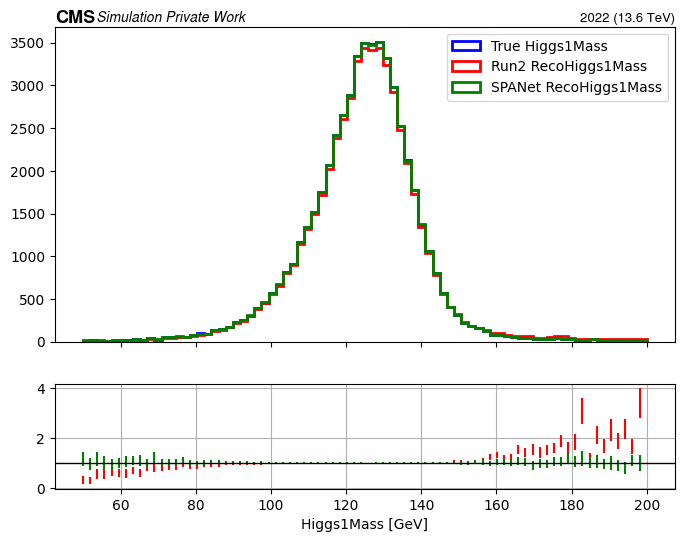

(array([  63,   47,   70,   65,   76,   85,   75,   94,   95,  120,  132,
        135,  150,  177,  212,  250,  263,  346,  368,  440,  483,  568,
        717,  814,  873, 1040, 1237, 1350, 1554, 1724, 1866, 2116, 2358,
       2338, 2580, 2742, 2909, 2871, 2823, 2712, 2522, 2288, 1985, 1633,
       1371, 1116,  811,  610,  441,  355,  233,  203,  170,  112,  106,
         85,   86,   78,   53,   59,   43,   42,   53,   43,   34,   36,
         36,   26,   26,   37,   26,   26,   14,   21,   18,   17,   26,
         24,   19]), array([ 50.        ,  51.89873418,  53.79746835,  55.69620253,
        57.59493671,  59.49367089,  61.39240506,  63.29113924,
        65.18987342,  67.08860759,  68.98734177,  70.88607595,
        72.78481013,  74.6835443 ,  76.58227848,  78.48101266,
        80.37974684,  82.27848101,  84.17721519,  86.07594937,
        87.97468354,  89.87341772,  91.7721519 ,  93.67088608,
        95.56962025,  97.46835443,  99.36708861, 101.26582278,
       103.16455696, 105.0

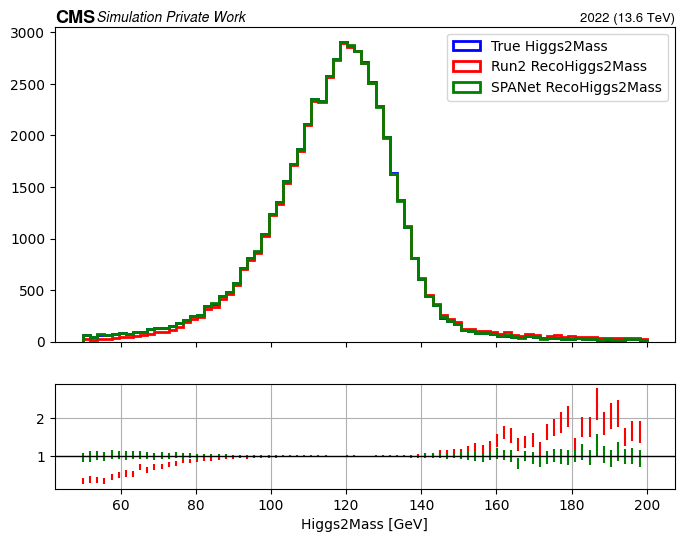

In [82]:
# for each event plot the mass of the higgs1 and higgs2
bins = np.linspace(50, 200, 80)
plot_histos(bins, true_higgs_fully_matched_mask[:,0].mass, run2_higgs_fully_matched[:,0].mass, pred_higgs_fully_matched_mask[:,0].mass, 1)
plot_histos(bins, true_higgs_fully_matched_mask[:,1].mass, run2_higgs_fully_matched[:,1].mass, pred_higgs_fully_matched_mask[:,1].mass, 2)
